In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

from sklearn.neighbors import KNeighborsRegressor
import statsmodels.api as sm
from sklearn.model_selection import cross_val_predict
import sklearn.linear_model as lm

In [2]:
!pip install xgboost

In [3]:
import pandas as pd
pd.set_option('display.max_columns', 50) # Display up to 50 columns at a time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
plt.style.use('seaborn')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,5
import glob # To read all csv files in the directory
import seaborn as sns
import calendar
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_fscore_support
import itertools
import time
import xgboost as xgb
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from numpy import arange

In [4]:
data = pd.read_excel('data_thesis1.xlsx','final data',skiprows = 0)
dates = pd.read_excel('data_thesis1.xlsx','final data',skiprows = 0, usecols = 'X')


In [5]:
data = data.drop(columns = ['year'])

In [6]:

# Converting dates from unit to datetime
cols_to_convert = ['start date', 'end date']
for c in cols_to_convert:
    data[c] = pd.to_datetime(data[c], origin='unix', unit='s')

In [7]:
print(f"The dataset contains projects added to Kickstarter between {min(data['start date']).strftime('%d %B %Y')} and {max(data['start date']).strftime('%d %B %Y')}.")

The dataset contains projects added to Kickstarter between 07 December 2018 and 05 March 2021.


In [8]:
## Adittional variables
# Launch day of week
data['start_day'] = data['start date'].dt.day_name()

# Deadline day of week
data['end_day'] = data['end date'].dt.day_name()

In [9]:
# Number of projects of different states
data.status.value_counts()

Successful    5605
Failed        3627
Name: status, dtype: int64

# Exploring the data

In [10]:
# Summary statistics for the numerical features
d = data.describe()

In [11]:
d.to_csv("descriptive.csv")

In [12]:
# Key statistics
print("Key stats:")
print("\nThe total amount of money that projects have aimed to raise is ${0:,.0f}".format(data.goal.sum()))
print("The total amount of money pledged by backers is ${0:,.0f}".format(data.funded.sum()))
print("The total amount of money pledged by backers to successful projects is ${0:,.0f}".format(sum(data.loc[data['status'] == 'Successful'].funded)))

print("\nThe total number of successful or failed projects launched on Kickstarter is: {0:,}".format(len(data)))
print("The total number of projects which were successfully funded is: {0:,}".format(len(data.loc[data['status'] == 'Successful'])))
print(f"The proportion of completed projects which were successfully funded is: {int(round((len(data.loc[data['status'] == 'Successful'])/len(data))*100,0))}%")

print("\nThe mean project fundraising goal is ${0:,.0f}".format(data.goal.mean()))
print("The mean amount pledged per project is ${0:,.0f}".format(data.funded.mean()))
print("The mean amount pledged per successful project is ${0:,.0f}".format(data.loc[data['status'] == 'Successful'].funded.mean()))
print("The mean amount pledged per failed project is ${0:,.0f}".format(data.loc[data['status'] == 'Failed'].funded.mean()))
      
print("\nThe mean number of backers per project is", int(round(data.backer.mean(),0)))
print("The mean number of backers per successful project is ${0:,.0f}".format(data.loc[data['status'] == 'Successful'].backer.mean()))
print("The mean number of backers per failed project is ${0:,.0f}".format(data.loc[data['status'] == 'Failed'].backer.mean()))
print("The mean pledge per backer is ${0:,.0f}".format(data.pledge_per_backer.mean()))
print("The mean pledge per backer per successful project is ${0:,.0f}".format(data.loc[data['status'] == 'Successful'].pledge_per_backer.mean()))
print("The mean pledge per backer per failed project is ${0:,.0f}".format(data.loc[data['status'] == 'Failed'].pledge_per_backer.mean()))
print("The mean number of days a campaign is run for is", int(round(data.duration.mean(),0)))
print("The mean number of days per successful project is ${0:,.0f}".format(data.loc[data['status'] == 'Successful'].duration.mean()))
print("The mean  number of days per failed project is ${0:,.0f}".format(data.loc[data['status'] == 'Failed'].duration.mean()))


print("\nThe mean number of googletrend searches per project is", int(round(data.googletrends.mean(),0)))
print("The mean number of googletrend searches per successful project is ${0:,.0f}".format(data.loc[data['status'] == 'Successful'].googletrends.mean()))
print("The mean number of googletrend searches per failed project is ${0:,.0f}".format(data.loc[data['status'] == 'Failed'].googletrends.mean()))
print("The mean number of updates is ${0:,.0f}".format(data.num_update.mean()))
print("The mean number of updates per successful project is ${0:,.0f}".format(data.loc[data['status'] == 'Successful'].num_update.mean()))
print("The mean number of updates per failed project is ${0:,.0f}".format(data.loc[data['status'] == 'Failed'].num_update.mean()))
print("The mean number of comments a campaign is run for is", int(round(data.num_comment.mean(),0)))
print("The mean number of comments per successful project is ${0:,.0f}".format(data.loc[data['status'] == 'Successful'].num_comment.mean()))
print("The mean number of comments per failed project is ${0:,.0f}".format(data.loc[data['status'] == 'Failed'].num_comment.mean()))

print("\nThe mean number of faqs per project is", int(round(data.num_faq.mean(),0)))
print("The mean number of faqs per successful project is ${0:,.0f}".format(data.loc[data['status'] == 'Successful'].num_faq.mean()))
print("The mean number of faqs per failed project is ${0:,.0f}".format(data.loc[data['status'] == 'Failed'].num_faq.mean()))
print("The mean number of reward tiers is ${0:,.0f}".format(data.num_tiers.mean()))
print("The mean number of reward tiers per successful project is ${0:,.0f}".format(data.loc[data['status'] == 'Successful'].num_tiers.mean()))
print("The mean number of reward tiers per failed project is ${0:,.0f}".format(data.loc[data['status'] == 'Failed'].num_tiers.mean()))
print("The mean number of projects created by owner is", int(round(data.num_created_by_owner.mean(),0)))
print("The mean number of projects created by owner per successful project is ${0:,.0f}".format(data.loc[data['status'] == 'Successful'].num_created_by_owner.mean()))
print("The mean  number of projects created by owner per failed project is ${0:,.0f}".format(data.loc[data['status'] == 'Failed'].num_created_by_owner.mean()))

Key stats:

The total amount of money that projects have aimed to raise is $187,128,578
The total amount of money pledged by backers is $192,289,277
The total amount of money pledged by backers to successful projects is $186,678,224

The total number of successful or failed projects launched on Kickstarter is: 9,232
The total number of projects which were successfully funded is: 5,605
The proportion of completed projects which were successfully funded is: 61%

The mean project fundraising goal is $20,270
The mean amount pledged per project is $20,829
The mean amount pledged per successful project is $33,306
The mean amount pledged per failed project is $1,547

The mean number of backers per project is 251
The mean number of backers per successful project is $400
The mean number of backers per failed project is $20
The mean pledge per backer is $70
The mean pledge per backer per successful project is $79
The mean pledge per backer per failed project is $55
The mean number of days a camp

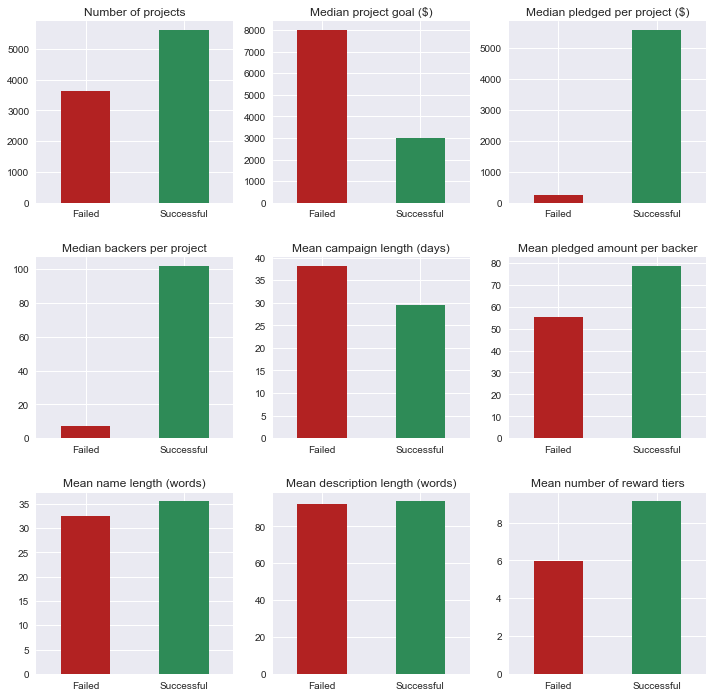

In [13]:

# Plotting the average amount pledged to successful and unsuccesful projects
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(12,12))

data['status'].value_counts(ascending=True).plot(kind='bar', ax=ax1, color=['firebrick', 'seagreen'], rot=0)
ax1.set_title('Number of projects')
ax1.set_xlabel('')

data.groupby('status').goal.median().plot(kind='bar', ax=ax2, color=['firebrick', 'seagreen'], rot=0)
ax2.set_title('Median project goal ($)')
ax2.set_xlabel('')

data.groupby('status').funded.median().plot(kind='bar', ax=ax3, color=['firebrick', 'seagreen'], rot=0)
ax3.set_title('Median pledged per project ($)')
ax3.set_xlabel('')

data.groupby('status').backer.median().plot(kind='bar', ax=ax4, color=['firebrick', 'seagreen'], rot=0)
ax4.set_title('Median backers per project')
ax4.set_xlabel('')

data.groupby('status').duration.mean().plot(kind='bar', ax=ax5, color=['firebrick', 'seagreen'], rot=0)
ax5.set_title('Mean campaign length (days)')
ax5.set_xlabel('')

data.groupby('status').pledge_per_backer.mean().plot(kind='bar', ax=ax6, color=['firebrick', 'seagreen'], rot=0)
ax6.set_title('Mean pledged amount per backer')
ax6.set_xlabel('')

data.groupby('status').len_title.mean().plot(kind='bar', ax=ax7, color=['firebrick', 'seagreen'], rot=0)
ax7.set_title('Mean name length (words)')
ax7.set_xlabel('')

data.groupby('status').len_desc.mean().plot(kind='bar', ax=ax8, color=['firebrick', 'seagreen'], rot=0)
ax8.set_title('Mean description length (words)')
ax8.set_xlabel('')

data.groupby('status').num_tiers.mean().plot(kind='bar', ax=ax9, color=['firebrick', 'seagreen'], rot=0)
ax9.set_title('Mean number of reward tiers')
ax9.set_xlabel('')




fig.subplots_adjust(hspace=0.3)
plt.show()

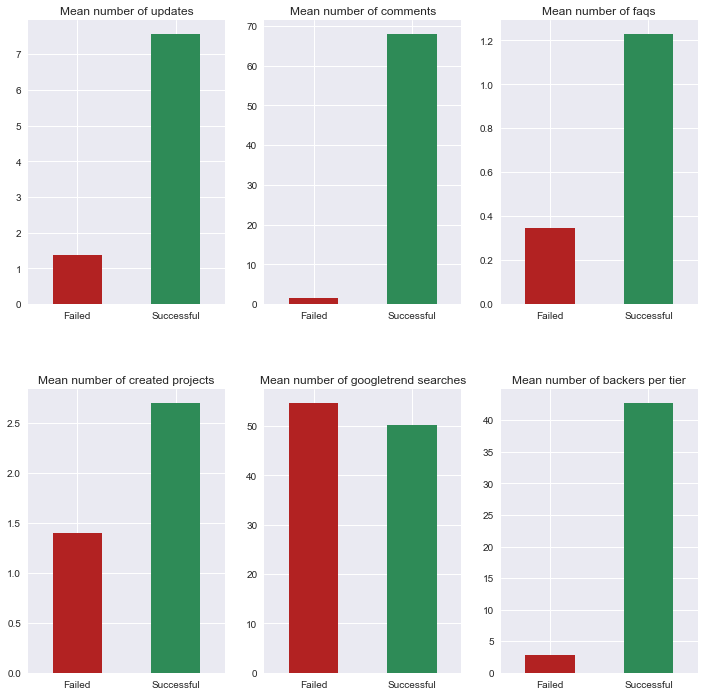

In [14]:
# Plotting the average amount pledged to successful and unsuccesful projects
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12,12))

data.groupby('status').num_update.mean().plot(kind='bar', ax=ax1, color=['firebrick', 'seagreen'], rot=0)
ax1.set_title('Mean number of updates')
ax1.set_xlabel('')

data.groupby('status').num_comment.mean().plot(kind='bar', ax=ax2, color=['firebrick', 'seagreen'], rot=0)
ax2.set_title('Mean number of comments')
ax2.set_xlabel('')

data.groupby('status').num_faq.mean().plot(kind='bar', ax=ax3, color=['firebrick', 'seagreen'], rot=0)
ax3.set_title('Mean number of faqs')
ax3.set_xlabel('')

data.groupby('status').num_created_by_owner.mean().plot(kind='bar', ax=ax4, color=['firebrick', 'seagreen'], rot=0)
ax4.set_title('Mean number of created projects')
ax4.set_xlabel('')

data.groupby('status').googletrends.mean().plot(kind='bar', ax=ax5, color=['firebrick', 'seagreen'], rot=0)
ax5.set_title('Mean number of googletrend searches')
ax5.set_xlabel('')

data.groupby('status').backer_per_tier.mean().plot(kind='bar', ax=ax6, color=['firebrick', 'seagreen'], rot=0)
ax6.set_title('Mean number of backers per tier')
ax6.set_xlabel('')

fig.subplots_adjust(hspace=0.3)
plt.show()




fig.subplots_adjust(hspace=0.3)
plt.show()

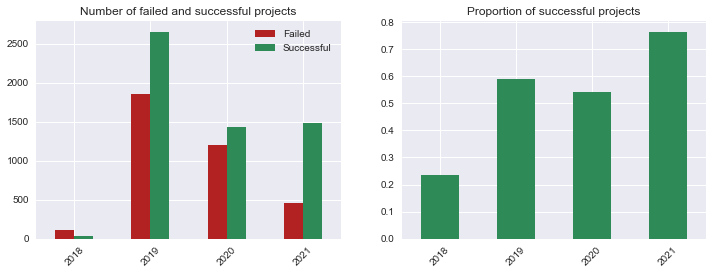

In [15]:
# Creating a dataframe grouped by year with columns for failed and successful
year_df = data.set_index('start date').status
year_df = pd.get_dummies(year_df).resample('YS').sum()

# Plotting the number and proportion of failed and successful projects each year
fig, ax = plt.subplots(1,2, figsize=(12,4))

year_df.plot.bar(ax=ax[0], color=['firebrick', 'seagreen'])
ax[0].set_title('Number of failed and successful projects')
ax[0].set_xlabel('')
ax[0].set_xticklabels(list(range(2018,2022)), rotation=45)

year_df.div(year_df.sum(axis=1), axis=0)['Successful'].plot(kind='bar', ax=ax[1], color='seagreen') # Normalizes counts across rows
ax[1].set_title('Proportion of successful projects')
ax[1].set_xlabel('')
ax[1].set_xticklabels(list(range(2018,2022)), rotation=45)

plt.show()

Text(0.5, 0, '')

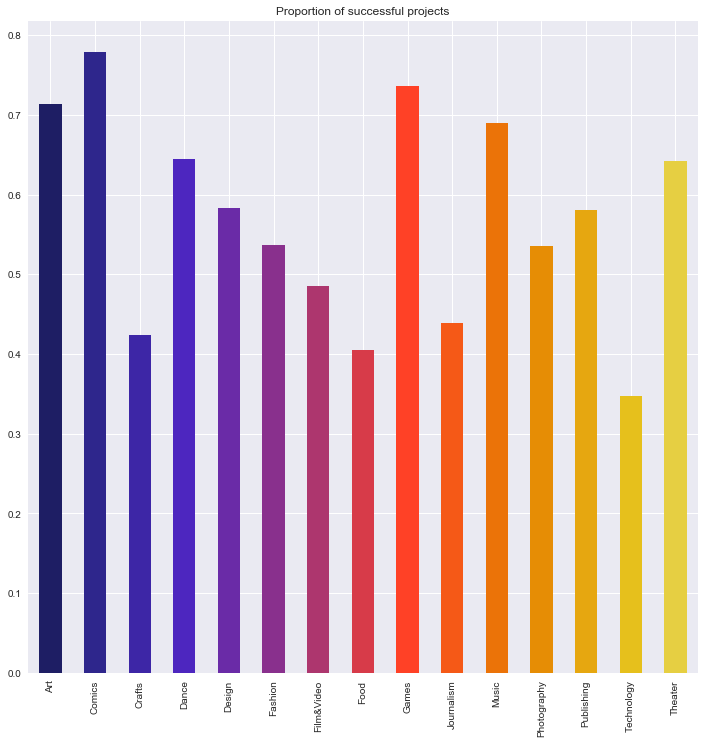

In [16]:
# Creating a dataframe grouped by category with columns for failed and successful
cat_df = pd.get_dummies(data.set_index('category').status).groupby('category').sum()

# Plotting
fig, (ax1) = plt.subplots(1, 1, figsize=(12,12))

color = cm.CMRmap(np.linspace(0.1,0.8,data.category.nunique())) # Setting a colormap
cat_df.div(cat_df.sum(axis=1), axis=0)['Successful'].plot(kind='bar', ax=ax1, color=color) # Normalizes counts across rows
ax1.set_title('Proportion of successful projects')
ax1.set_xlabel('')

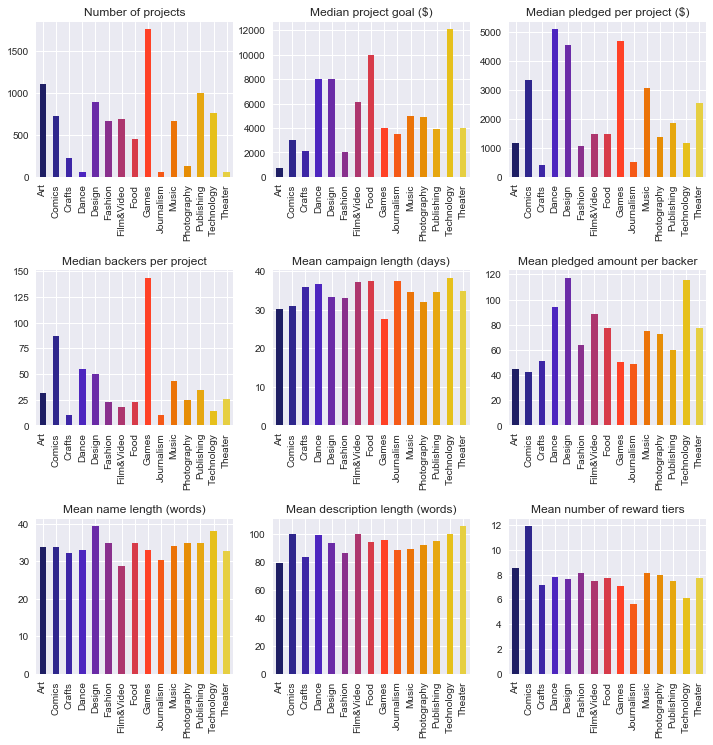

In [17]:
# Creating a dataframe grouped by category with columns for failed and successful
cat_df = pd.get_dummies(data.set_index('category').status).groupby('category').sum()

# Plotting
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(12,12))

color = cm.CMRmap(np.linspace(0.1,0.8,data.category.nunique())) # Setting a colormap

data.groupby('category').category.count().plot(kind='bar', ax=ax1, color=color)
ax1.set_title('Number of projects')
ax1.set_xlabel('')

data.groupby('category').goal.median().plot(kind='bar', ax=ax2, color=color)
ax2.set_title('Median project goal ($)')
ax2.set_xlabel('')

data.groupby('category').funded.median().plot(kind='bar', ax=ax3, color=color)
ax3.set_title('Median pledged per project ($)')
ax3.set_xlabel('')

data.groupby('category').backer.median().plot(kind='bar', ax=ax4, color=color)
ax4.set_title('Median backers per project')
ax4.set_xlabel('')

data.groupby('category').duration.mean().plot(kind='bar', ax=ax5, color=color)
ax5.set_title('Mean campaign length (days)')
ax5.set_xlabel('')

data.groupby('category').pledge_per_backer.mean().plot(kind='bar', ax=ax6, color=color)
ax6.set_title('Mean pledged amount per backer')
ax6.set_xlabel('')

data.groupby('category').len_title.mean().plot(kind='bar', ax=ax7, color=color)
ax7.set_title('Mean name length (words)')
ax7.set_xlabel('')

data.groupby('category').len_desc.mean().plot(kind='bar', ax=ax8, color=color)
ax8.set_title('Mean description length (words)')
ax8.set_xlabel('')

data.groupby('category').num_tiers.mean().plot(kind='bar', ax=ax9, color=color)
ax9.set_title('Mean number of reward tiers')
ax9.set_xlabel('')


fig.subplots_adjust(hspace=0.6)
plt.show()

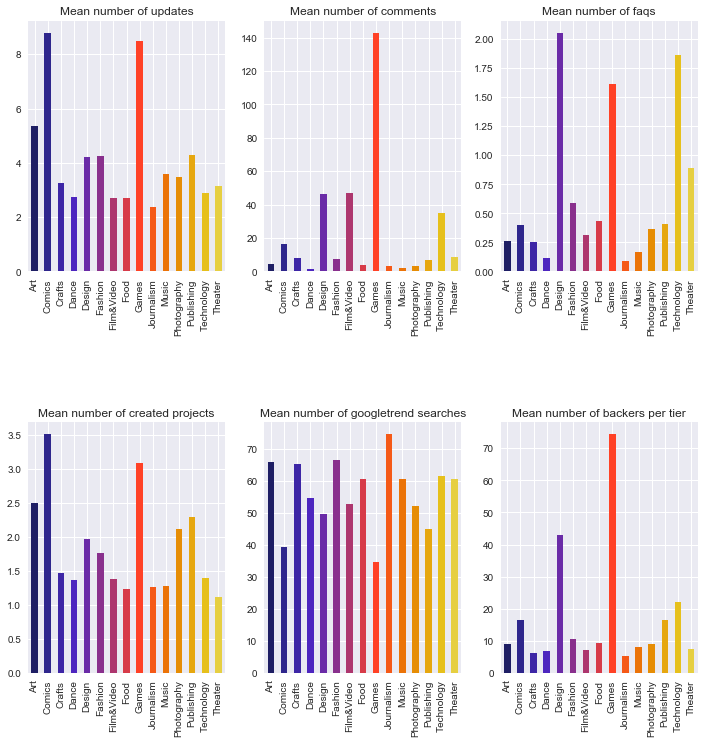

In [18]:
# Creating a dataframe grouped by category with columns for failed and successful
cat_df = pd.get_dummies(data.set_index('category').status).groupby('category').sum()

# Plotting
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12,12))

color = cm.CMRmap(np.linspace(0.1,0.8,data.category.nunique())) # Setting a colormap


data.groupby('category').num_update.mean().plot(kind='bar', ax=ax1, color=color)
ax1.set_title('Mean number of updates')
ax1.set_xlabel('')

data.groupby('category').num_comment.mean().plot(kind='bar', ax=ax2, color=color)
ax2.set_title('Mean number of comments')
ax2.set_xlabel('')

data.groupby('category').num_faq.mean().plot(kind='bar', ax=ax3, color=color)
ax3.set_title('Mean number of faqs')
ax3.set_xlabel('')

data.groupby('category').num_created_by_owner.mean().plot(kind='bar', ax=ax4, color=color)
ax4.set_title('Mean number of created projects')
ax4.set_xlabel('')

data.groupby('category').googletrends.mean().plot(kind='bar', ax=ax5, color=color)
ax5.set_title('Mean number of googletrend searches')
ax5.set_xlabel('')

data.groupby('category').backer_per_tier.mean().plot(kind='bar', ax=ax6, color=color)
ax6.set_title('Mean number of backers per tier')
ax6.set_xlabel('')




fig.subplots_adjust(hspace=0.6)
plt.show()

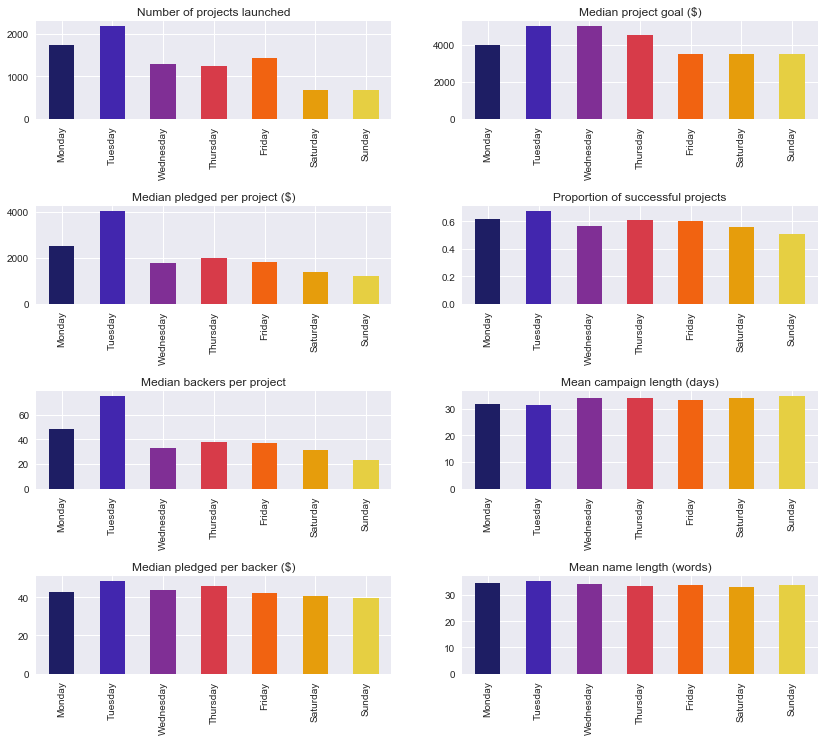

In [19]:
# Creating a dataframe grouped by the day on which they were launched, with columns for failed and successful
day_data = pd.get_dummies(data.set_index('start_day').status).groupby('start_day').sum()

# Plotting
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6),(ax7, ax8)) = plt.subplots(4, 2, figsize=(14,12))

color = cm.CMRmap(np.linspace(0.1,0.8,data.start_day.nunique()))

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

data.groupby('start_day').start_day.count().reindex(weekdays).plot(kind='bar', ax=ax1, color=color)
ax1.set_title('Number of projects launched')
ax1.set_xlabel('')

data.groupby('start_day').goal.median().reindex(weekdays).plot(kind='bar', ax=ax2, color=color)
ax2.set_title('Median project goal ($)')
ax2.set_xlabel('')

data.groupby('start_day').funded.median().reindex(weekdays).plot(kind='bar', ax=ax3, color=color)
ax3.set_title('Median pledged per project ($)')
ax3.set_xlabel('')

day_data.div(day_data.sum(axis=1), axis=0)['Successful'].reindex(weekdays).plot(kind='bar', ax=ax4, color=color) # Normalizes counts across rows
ax4.set_title('Proportion of successful projects')
ax4.set_xlabel('')

data.groupby('start_day').backer.median().reindex(weekdays).plot(kind='bar', ax=ax5, color=color)
ax5.set_title('Median backers per project')
ax5.set_xlabel('')

data.groupby('start_day').duration.mean().reindex(weekdays).plot(kind='bar', ax=ax6, color=color)
ax6.set_title('Mean campaign length (days)')
ax6.set_xlabel('')

data.groupby('start_day').pledge_per_backer.median().reindex(weekdays).plot(kind='bar', ax=ax7, color=color)
ax7.set_title('Median pledged per backer ($)')
ax7.set_xlabel('')


data.groupby('start_day').len_title.mean().reindex(weekdays).plot(kind='bar', ax=ax8, color=color)
ax8.set_title('Mean name length (words)')
ax8.set_xlabel('')



fig.subplots_adjust(hspace=0.9)
plt.show()




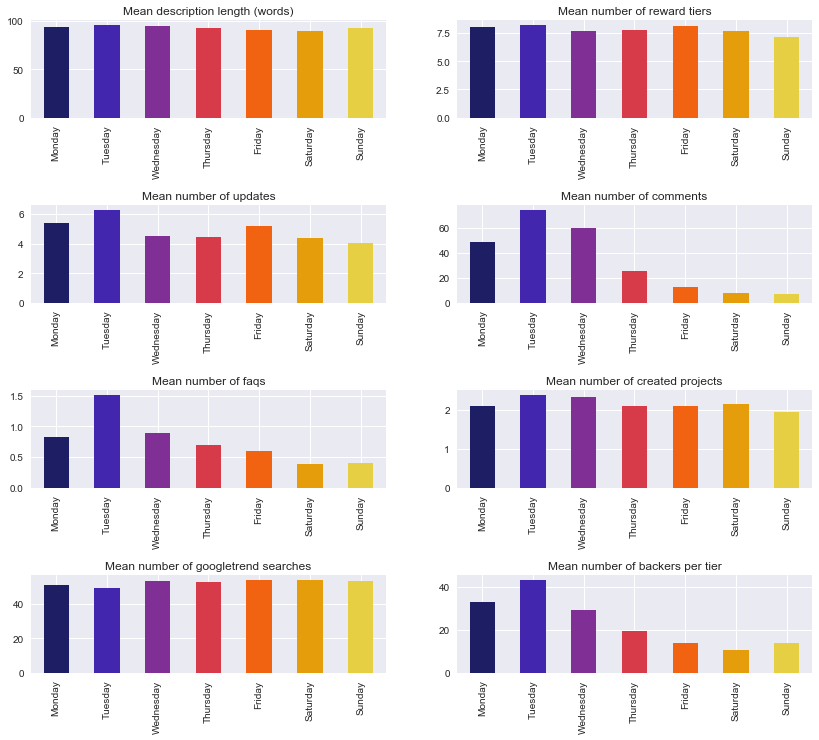

In [20]:
# Creating a dataframe grouped by the day on which they were launched, with columns for failed and successful
day_data = pd.get_dummies(data.set_index('start_day').status).groupby('start_day').sum()

# Plotting
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6),(ax7, ax8)) = plt.subplots(4, 2, figsize=(14,12))

color = cm.CMRmap(np.linspace(0.1,0.8,data.start_day.nunique()))

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

data.groupby('start_day').len_desc.mean().reindex(weekdays).plot(kind='bar', ax=ax1, color=color)
ax1.set_title('Mean description length (words)')
ax1.set_xlabel('')

data.groupby('start_day').num_tiers.mean().reindex(weekdays).plot(kind='bar', ax=ax2, color=color)
ax2.set_title('Mean number of reward tiers')
ax2.set_xlabel('')


data.groupby('start_day').num_update.mean().reindex(weekdays).plot(kind='bar', ax=ax3, color=color)
ax3.set_title('Mean number of updates')
ax3.set_xlabel('')

data.groupby('start_day').num_comment.mean().reindex(weekdays).plot(kind='bar', ax=ax4, color=color)
ax4.set_title('Mean number of comments')
ax4.set_xlabel('')

data.groupby('start_day').num_faq.mean().reindex(weekdays).plot(kind='bar', ax=ax5, color=color)
ax5.set_title('Mean number of faqs')
ax5.set_xlabel('')

data.groupby('start_day').num_created_by_owner.mean().reindex(weekdays).plot(kind='bar', ax=ax6, color=color)
ax6.set_title('Mean number of created projects')
ax6.set_xlabel('')

data.groupby('start_day').googletrends.mean().reindex(weekdays).plot(kind='bar', ax=ax7, color=color)
ax7.set_title('Mean number of googletrend searches')
ax7.set_xlabel('')

data.groupby('start_day').backer_per_tier.mean().reindex(weekdays).plot(kind='bar', ax=ax8, color=color)
ax8.set_title('Mean number of backers per tier')
ax8.set_xlabel('')


fig.subplots_adjust(hspace=0.9)
plt.show()













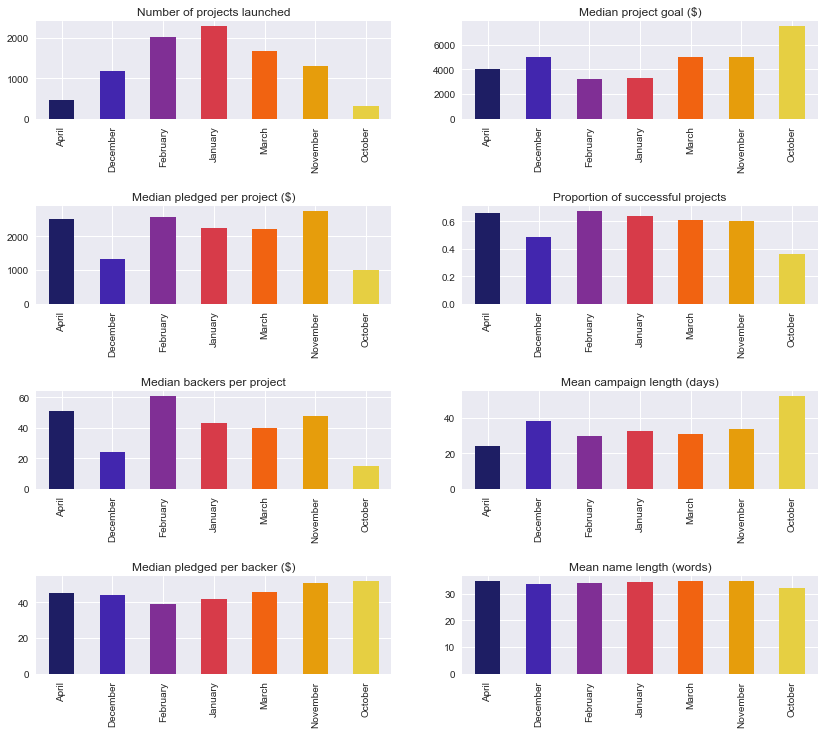

In [21]:
# Creating a dataframe grouped by the month in which they were launched, with columns for failed and successful
month_df = pd.get_dummies(data.set_index('launch_month').status).groupby('launch_month').sum()

# Plotting



fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6),(ax7, ax8)) = plt.subplots(4, 2, figsize=(14,12))

color = cm.CMRmap(np.linspace(0.1,0.8,data.launch_month.nunique()))



data.groupby('launch_month').launch_month.count().plot(kind='bar', ax=ax1, color=color)
ax1.set_title('Number of projects launched')
ax1.set_xlabel('')

data.groupby('launch_month').goal.median().plot(kind='bar', ax=ax2, color=color)
ax2.set_title('Median project goal ($)')
ax2.set_xlabel('')

data.groupby('launch_month').funded.median().plot(kind='bar', ax=ax3, color=color)
ax3.set_title('Median pledged per project ($)')
ax3.set_xlabel('')

month_df.div(month_df.sum(axis=1), axis=0)['Successful'].plot(kind='bar', ax=ax4, color=color) # Normalizes counts across rows
ax4.set_title('Proportion of successful projects')
ax4.set_xlabel('')

data.groupby('launch_month').backer.median().plot(kind='bar', ax=ax5, color=color)
ax5.set_title('Median backers per project')
ax5.set_xlabel('')

data.groupby('launch_month').duration.mean().plot(kind='bar', ax=ax6, color=color)
ax6.set_title('Mean campaign length (days)')
ax6.set_xlabel('')

data.groupby('launch_month').pledge_per_backer.median().plot(kind='bar', ax=ax7, color=color)
ax7.set_title('Median pledged per backer ($)')
ax7.set_xlabel('')


data.groupby('launch_month').len_title.mean().plot(kind='bar', ax=ax8, color=color)
ax8.set_title('Mean name length (words)')
ax8.set_xlabel('')


fig.subplots_adjust(hspace=0.9)
plt.show()


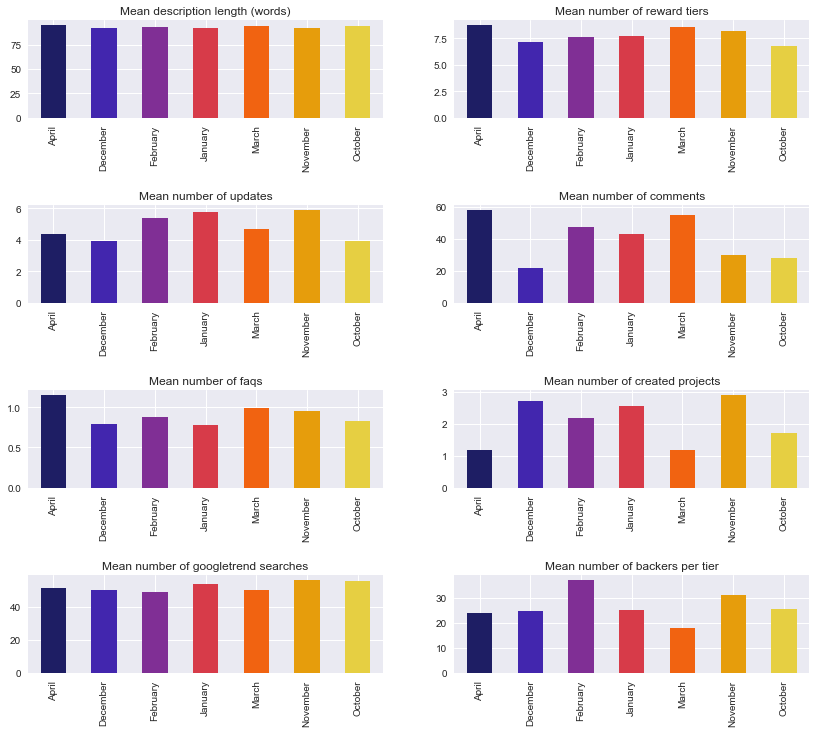

In [22]:
# Creating a dataframe grouped by the month in which they were launched, with columns for failed and successful
month_df = pd.get_dummies(data.set_index('launch_month').status).groupby('launch_month').sum()

# Plotting



fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6),(ax7, ax8)) = plt.subplots(4, 2, figsize=(14,12))

color = cm.CMRmap(np.linspace(0.1,0.8,data.launch_month.nunique()))

data.groupby('launch_month').len_desc.mean().plot(kind='bar', ax=ax1, color=color)
ax1.set_title('Mean description length (words)')
ax1.set_xlabel('')

data.groupby('launch_month').num_tiers.mean().plot(kind='bar', ax=ax2, color=color)
ax2.set_title('Mean number of reward tiers')
ax2.set_xlabel('')


data.groupby('launch_month').num_update.mean().plot(kind='bar', ax=ax3, color=color)
ax3.set_title('Mean number of updates')
ax3.set_xlabel('')

data.groupby('launch_month').num_comment.mean().plot(kind='bar', ax=ax4, color=color)
ax4.set_title('Mean number of comments')
ax4.set_xlabel('')

data.groupby('launch_month').num_faq.mean().plot(kind='bar', ax=ax5, color=color)
ax5.set_title('Mean number of faqs')
ax5.set_xlabel('')

data.groupby('launch_month').num_created_by_owner.mean().plot(kind='bar', ax=ax6, color=color)
ax6.set_title('Mean number of created projects')
ax6.set_xlabel('')

data.groupby('launch_month').googletrends.mean().plot(kind='bar', ax=ax7, color=color)
ax7.set_title('Mean number of googletrend searches')
ax7.set_xlabel('')

data.groupby('launch_month').backer_per_tier.mean().plot(kind='bar', ax=ax8, color=color)
ax8.set_title('Mean number of backers per tier')
ax8.set_xlabel('')


fig.subplots_adjust(hspace=0.9)
plt.show()


# Modeling

# Checking distributions

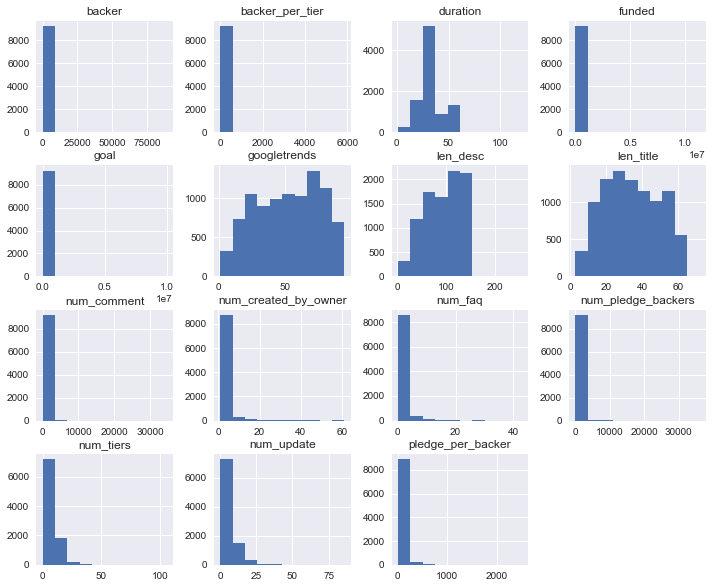

In [23]:

# Checking the distributions of continuous features
data[data.describe().columns].hist(figsize=(12,10));

# Preparing the data for machine learning

In [24]:
df_transformed = data.drop(['backer', 'pledge_per_backer', 'funded', 'num_update', 'num_comment', 'num_pledge_backers', 'backer_per_tier', 'num_faq','start date','end date','subcategory','country','start_day','end_day', 'launch_month','deadline_month'], axis=1)

In [25]:
df_transformed

,status,category,googletrends,duration,goal,len_desc,len_title,num_tiers,featured,num_created_by_owner
0,Successful,Film&Video,37,31,1200,133,11,4,Not Featured,1
1,Failed,Fashion,65,30,20000,11,8,3,Not Featured,1
2,Failed,Design,83,30,21000,33,3,7,Not Featured,1
3,Successful,Photography,81,60,1000,126,36,4,Not Featured,1
4,Failed,Art,76,30,10000,47,14,2,Not Featured,1
...,...,...,...,...,...,...,...,...,...,...
9227,Successful,Film&Video,68,60,500,96,17,6,Not Featured,1
9228,Failed,Games,87,30,5000,126,56,9,Not Featured,1
9229,Failed,Games,63,30,1000,133,32,7,Not Featured,2
9230,Successful,Games,62,30,10000,129,57,11,Featured,1


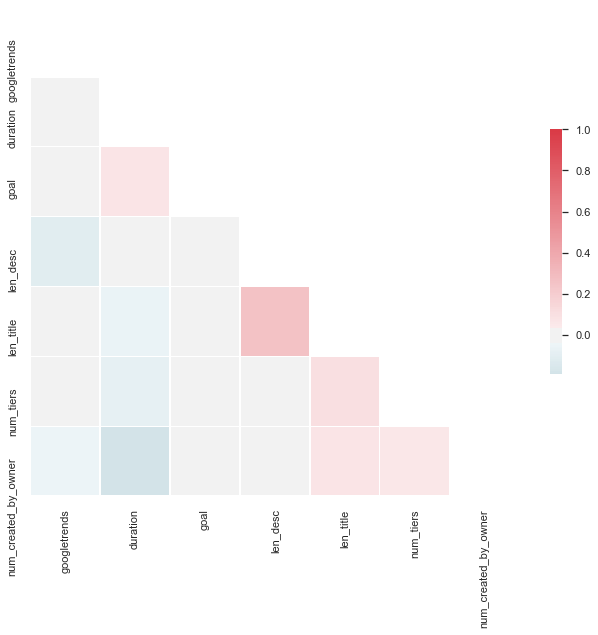

In [26]:
# Set the style of the visualization
sns.set(style="white")

# Create a covariance matrix
corr = df_transformed.corr()

# Generate a mask the size of our covariance matrix
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11,9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [27]:
df_transformed1 = pd.get_dummies(df_transformed, columns=['category'], drop_first = True)

In [28]:
df_transformed1 = pd.get_dummies(df_transformed1, columns=['status','featured'])

In [29]:
df_transformed1.drop('status_Failed', inplace=True, axis=1)

In [30]:
df_transformed1.drop('featured_Not Featured', inplace=True, axis=1)

In [31]:
df_transformed1

,googletrends,duration,goal,len_desc,len_title,num_tiers,num_created_by_owner,category_Comics,category_Crafts,category_Dance,category_Design,category_Fashion,category_Film&Video,category_Food,category_Games,category_Journalism,category_Music,category_Photography,category_Publishing,category_Technology,category_Theater,status_Successful,featured_Featured
0,37,31,1200,133,11,4,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,65,30,20000,11,8,3,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,83,30,21000,33,3,7,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,81,60,1000,126,36,4,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,76,30,10000,47,14,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9227,68,60,500,96,17,6,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
9228,87,30,5000,126,56,9,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
9229,63,30,1000,133,32,7,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
9230,62,30,10000,129,57,11,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1


In [32]:
X_unscaled = df_transformed1.drop(columns = ['status_Successful','len_desc','category_Dance', 'category_Music', 'category_Games'], axis=1)
y = df_transformed1['status_Successful']

In [33]:
#Scaling independent variables
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X_unscaled), columns=list(X_unscaled.columns))
X.head()

,googletrends,duration,goal,len_title,num_tiers,num_created_by_owner,category_Comics,category_Crafts,category_Design,category_Fashion,category_Film&Video,category_Food,category_Journalism,category_Photography,category_Publishing,category_Technology,category_Theater,featured_Featured
0,-0.621960,-0.145331,-0.099604,-1.519260,-0.652132,-0.267702,-0.290838,-0.160199,-0.327039,-0.278384,3.535120,-0.22821,-0.07882,-0.117157,-0.348536,-0.298867,-0.075987,-0.37534
1,0.540694,-0.222131,-0.001408,-1.714824,-0.820259,-0.267702,-0.290838,-0.160199,-0.327039,3.592160,-0.282876,-0.22821,-0.07882,-0.117157,-0.348536,-0.298867,-0.075987,-0.37534
2,1.288114,-0.222131,0.003815,-2.040763,-0.147749,-0.267702,-0.290838,-0.160199,3.057740,-0.278384,-0.282876,-0.22821,-0.07882,-0.117157,-0.348536,-0.298867,-0.075987,-0.37534
3,1.205067,2.081870,-0.100649,0.110435,-0.652132,-0.267702,-0.290838,-0.160199,-0.327039,-0.278384,-0.282876,-0.22821,-0.07882,8.535573,-0.348536,-0.298867,-0.075987,-0.37534
4,0.997451,-0.222131,-0.053640,-1.323697,-0.988387,-0.267702,-0.290838,-0.160199,-0.327039,-0.278384,-0.282876,-0.22821,-0.07882,-0.117157,-0.348536,-0.298867,-0.075987,-0.37534


# Estimating the relationship by OLS

In [34]:
X_ = sm.add_constant(X)

In [35]:
model = sm.OLS(y,X_)


In [36]:
results = model.fit()

In [37]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      status_Successful   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     169.5
Date:                Fri, 30 Apr 2021   Prob (F-statistic):               0.00
Time:                        16:15:50   Log-Likelihood:                -5163.2
No. Observations:                9232   AIC:                         1.036e+04
Df Residuals:                    9213   BIC:                         1.050e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.6071 

# Modeling

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=123)

# Model 1: Logistic regression

In [39]:
logreg = lm.LogisticRegression()
model = logreg.fit(X,y)
print(model.coef_, model.intercept_)


[[-1.41033347e-01 -5.43681447e-01 -5.43894814e+00  1.53560272e-01
   7.97566108e-01  3.40525318e-01 -1.10091746e-01 -1.56685094e-01
  -1.30396256e-01 -1.59870827e-01 -1.56462101e-01 -2.32318080e-01
  -6.97679891e-02 -1.09782700e-01 -2.43784170e-01 -2.25921600e-01
   4.68513759e-03  8.83171665e-01]] [0.45996893]


In [40]:
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

In [41]:
# Logistic regression scores
print("Logistic regression score for training set:", round(logreg.score(X, y),5))
print("Logistic regression score for test set:", round(logreg.score(X_test, y_test),5))
print("\nClassification report:")
print(classification_report(y_test, y_hat_test))

Logistic regression score for training set: 0.76246
Logistic regression score for test set: 0.76065

Classification report:
              precision    recall  f1-score   support

           0       0.72      0.60      0.65      1047
           1       0.78      0.86      0.82      1723

    accuracy                           0.76      2770
   macro avg       0.75      0.73      0.74      2770
weighted avg       0.76      0.76      0.76      2770



In [42]:
def plot_cf(y_true, y_pred, class_names=None, model_name=None):
    """Plots a confusion matrix"""
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    plt.grid(b=None)
    if model_name:
        plt.title("Confusion Matrix: {}".format(model_name))
    else:
        plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    class_names = set(y_true)
    tick_marks = np.arange(len(class_names))
    if class_names:
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')

    plt.colorbar()

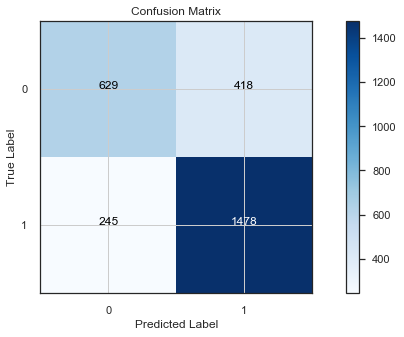

In [43]:
# Confusion matrix
plot_cf(y_test, y_hat_test)

AUC: 0.82588


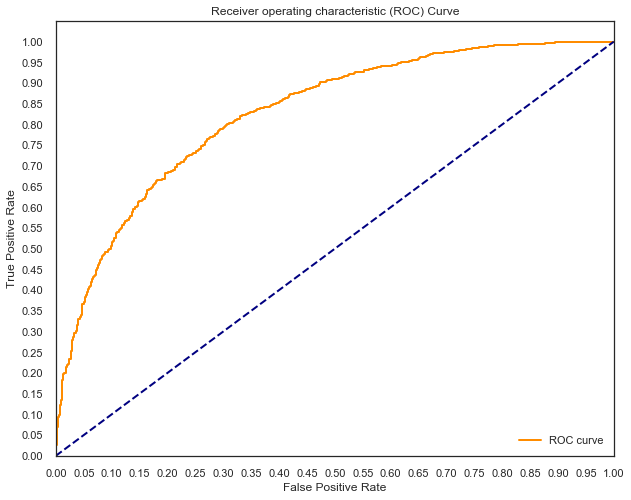

In [44]:
# Plotting the AUC-ROC
y_score = logreg.fit(X_train, y_train).decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score)

print('AUC:', round(auc(fpr, tpr),5))

plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Principal Component Analysis and feature weightings

In [45]:

pca = PCA()
pca.fit_transform(X)
explained_var = np.cumsum(pca.explained_variance_ratio_)

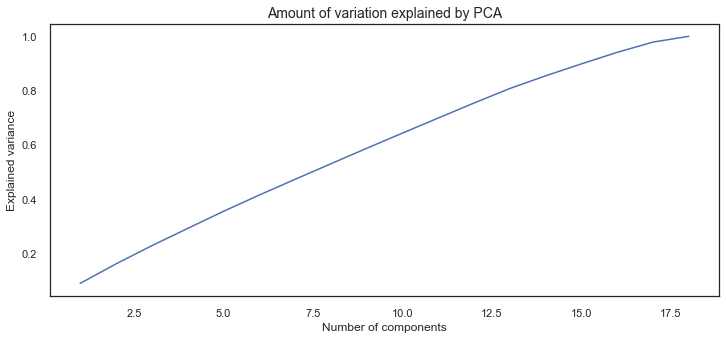

In [46]:

# Plotting the amount of variation explained by PCA with different numbers of components
plt.plot(list(range(1, len(explained_var)+1)), explained_var)
plt.title('Amount of variation explained by PCA', fontsize=14)
plt.xlabel('Number of components')
plt.ylabel('Explained variance');

In [47]:
print("Number of components explaining 80% of variance:", np.where(explained_var > 0.8)[0][0])
print("Number of components explaining 90% of variance:", np.where(explained_var > 0.9)[0][0])
print("Number of components explaining 99% of variance:", np.where(explained_var > 0.99)[0][0])

Number of components explaining 80% of variance: 12
Number of components explaining 90% of variance: 15
Number of components explaining 99% of variance: 17


In [48]:
n_comps = [12,15,17]
for n in n_comps:
    pipe = Pipeline([('pca', PCA(n_components=n)), ('clf', LogisticRegression())])
    pipe.fit(X_train, y_train)
    print("\nNumber of components:", n)
    print("Score:", round(pipe.score(X_test, y_test),5))


Number of components: 12
Score: 0.73899

Number of components: 15
Score: 0.74621

Number of components: 17
Score: 0.76137


In [49]:
pca = PCA(n_components=17)
pca.fit_transform(X)
pca_30_components = pd.DataFrame(pca.components_,columns=X.columns).T # Components as columns, features as rows
pca_30_components['mean_weight'] = pca_30_components.iloc[:].abs().mean(axis=1)
pca_30_components.sort_values('mean_weight', ascending=False)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,mean_weight
num_tiers,-0.366364,-0.189997,0.224212,0.245556,0.221129,0.146492,0.155024,0.028822,-0.140305,0.009120,0.251433,-0.174931,-0.204305,-0.004526,0.270252,0.490994,0.392962,0.206849
num_created_by_owner,-0.349091,-0.206163,-0.020460,-0.119657,-0.091327,-0.200922,-0.108528,0.157801,0.129043,-0.158729,-0.020540,0.417483,0.257524,0.324533,-0.466458,0.347354,0.091809,0.203966
category_Film&Video,0.122053,0.351142,0.315222,0.264021,-0.256437,-0.067710,0.148117,0.291675,0.099682,-0.150249,0.203934,0.304655,-0.422506,0.204071,0.025478,-0.054349,-0.096827,0.198713
googletrends,0.331702,-0.412366,0.248491,-0.098376,0.190606,0.098759,-0.046130,0.250050,-0.011007,-0.049399,0.167233,0.109757,-0.076725,-0.288095,-0.065829,0.298823,-0.545974,0.193489
len_title,-0.159197,-0.359941,-0.409464,0.033998,0.255597,0.081088,0.103166,0.075371,-0.019083,-0.046214,0.196480,0.016711,-0.290505,0.516623,0.109742,-0.347970,-0.239633,0.191811
featured_Featured,-0.378151,0.159379,0.100754,-0.070982,0.305250,0.157698,-0.007634,0.304533,-0.004456,-0.030944,0.188866,0.023157,-0.095972,-0.422687,-0.420989,-0.427589,0.119690,0.189337
duration,0.341057,0.329454,-0.057016,0.180308,0.277872,0.086751,0.126390,-0.077141,-0.154834,0.045067,0.042432,-0.291260,-0.068326,0.320591,-0.558711,0.240072,0.005087,0.188375
category_Comics,-0.418125,0.031227,0.248388,0.358575,0.145994,-0.194509,-0.036030,-0.195719,-0.122512,0.097280,-0.245788,-0.219507,0.141479,0.027391,-0.078932,-0.036993,-0.535883,0.184372
category_Fashion,0.156909,-0.424995,0.300230,-0.225834,-0.177787,-0.023432,0.502629,-0.051395,-0.132773,0.006359,0.012086,-0.251600,0.100722,0.080968,-0.252427,-0.241505,0.183720,0.183845
category_Journalism,0.064833,-0.010238,0.118494,-0.101063,0.109513,0.117294,-0.278000,0.666881,0.076016,0.154509,-0.429274,-0.317618,0.044599,0.252638,0.122744,-0.006027,0.111553,0.175370


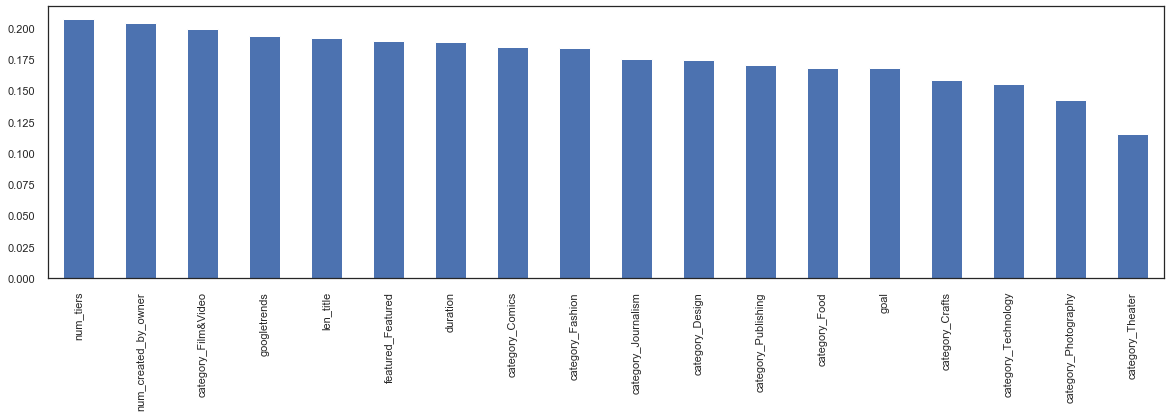

In [50]:
# Plotting feature importances
plt.figure(figsize=(20,5))
pca_30_components.mean_weight.sort_values(ascending=False).plot(kind='bar')
plt.show()

In [51]:
pca_30_components[0].map(lambda x : x).abs().sort_values(ascending = False)[:10]

category_Comics         0.418125
featured_Featured       0.378151
num_tiers               0.366364
num_created_by_owner    0.349091
duration                0.341057
googletrends            0.331702
category_Technology     0.261655
len_title               0.159197
category_Fashion        0.156909
category_Publishing     0.149139
Name: 0, dtype: float64

In [52]:
pca_30_components[1].map(lambda x : x).abs().sort_values(ascending = False)[:10]

category_Fashion        0.424995
googletrends            0.412366
category_Publishing     0.371300
len_title               0.359941
category_Film&Video     0.351142
duration                0.329454
num_created_by_owner    0.206163
num_tiers               0.189997
featured_Featured       0.159379
category_Design         0.144451
Name: 1, dtype: float64

In [53]:
pca_30_components[2].map(lambda x : x).abs().sort_values(ascending = False)[:10]

category_Design        0.545398
len_title              0.409464
category_Film&Video    0.315222
category_Fashion       0.300230
googletrends           0.248491
category_Comics        0.248388
category_Technology    0.244671
num_tiers              0.224212
category_Publishing    0.210379
category_Crafts        0.138933
Name: 2, dtype: float64

In [54]:
pca_30_components[5].map(lambda x : x).abs().sort_values(ascending = False)[:10]

category_Food           0.634109
category_Technology     0.560308
category_Design         0.324725
num_created_by_owner    0.200922
category_Comics         0.194509
featured_Featured       0.157698
num_tiers               0.146492
category_Journalism     0.117294
googletrends            0.098759
duration                0.086751
Name: 5, dtype: float64

# Model 2: logistic regression with PCA and parameter optimisation 

In [55]:
# Using GridSearchCV to test multiple different parameters
logreg_start = time.time()

pipe_logreg = Pipeline([('pca', PCA(n_components=17)),
                    ('clf', LogisticRegression())])

params_logreg = [
    {'clf__penalty': ['l1', 'l2'],
     'clf__fit_intercept': [True, False],
        'clf__C': [0.001, 0.01, 1, 10]
    }
]

grid_logreg = GridSearchCV(estimator=pipe_logreg,
                  param_grid=params_logreg,
                  cv=5)

grid_logreg.fit(X_train, y_train)

logreg_end = time.time()

logreg_best_score = grid_logreg.best_score_
logreg_best_params = grid_logreg.best_params_

print(f"Time taken to run: {round((logreg_end - logreg_start)/60,1)} minutes")
print("Best accuracy:", round(logreg_best_score,2))
print("Best parameters:", logreg_best_params)

C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\L.Arustamyan\

Time taken to run: 0.0 minutes
Best accuracy: 0.76
Best parameters: {'clf__C': 10, 'clf__fit_intercept': False, 'clf__penalty': 'l2'}


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


# Best logistic regression model

Logistic regression score for training set: 0.76323
Logistic regression score for test set: 0.76173

Classification report:
              precision    recall  f1-score   support

           0       0.70      0.64      0.67      1047
           1       0.79      0.83      0.81      1723

    accuracy                           0.76      2770
   macro avg       0.75      0.74      0.74      2770
weighted avg       0.76      0.76      0.76      2770



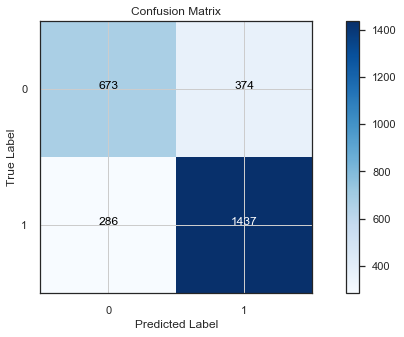

In [56]:
pipe_best_logreg = Pipeline([('pca', PCA(n_components=17)),
                    ('clf', LogisticRegression(C=10, fit_intercept=False, penalty='l2'))])

pipe_best_logreg.fit(X_train, y_train)

lr_y_hat_train = pipe_best_logreg.predict(X_train)
lr_y_hat_test = pipe_best_logreg.predict(X_test)

print("Logistic regression score for training set:", round(pipe_best_logreg.score(X_train, y_train),5))
print("Logistic regression score for test set:", round(pipe_best_logreg.score(X_test, y_test),5))
print("\nClassification report:")
print(classification_report(y_test, lr_y_hat_test))
plot_cf(y_test, lr_y_hat_test)

# Model 3: Random Forests

In [57]:
# Random Forests with default settings
pipe_rf = Pipeline([('pca', PCA(n_components=17)),
                    ('clf', RandomForestClassifier())])
pipe_rf.fit(X_train, y_train)
print("Score:", round(pipe_rf.score(X_test, y_test),5))

Score: 0.73935


In [58]:

# Reporting the depths of each tree in the model created by the default Random Forest classifier, to get a sense of the
# maximum depth that a tree can be if depth is not limited, to help with choosing parameters to try with GridSearchCV
[estimator.tree_.max_depth for estimator in pipe_rf.named_steps['clf'].estimators_]


[24,
 27,
 31,
 24,
 24,
 28,
 28,
 27,
 24,
 26,
 28,
 28,
 25,
 26,
 26,
 26,
 26,
 25,
 28,
 31,
 26,
 29,
 25,
 26,
 34,
 27,
 22,
 24,
 29,
 24,
 28,
 34,
 25,
 23,
 28,
 29,
 28,
 29,
 32,
 30,
 25,
 24,
 27,
 25,
 24,
 26,
 28,
 25,
 24,
 29,
 26,
 22,
 32,
 33,
 24,
 31,
 29,
 30,
 24,
 24,
 30,
 28,
 27,
 30,
 23,
 24,
 21,
 28,
 25,
 25,
 26,
 24,
 29,
 26,
 27,
 30,
 23,
 24,
 28,
 37,
 20,
 31,
 24,
 27,
 26,
 32,
 29,
 29,
 24,
 29,
 24,
 25,
 33,
 32,
 27,
 25,
 26,
 27,
 26,
 25]

In [227]:

# Using GridSearchCV to test multiple different parameters
rf_start = time.time()

pipe_rf = Pipeline([('pca', PCA(n_components=17)),
                    ('clf', RandomForestClassifier())])

params_rf = [ 
  {'clf__n_estimators': [100],
   'clf__max_depth': [20, 30, 40],    
   'clf__min_samples_split':[0.001, 0.01]
  }
]

grid_rf = GridSearchCV(estimator=pipe_rf,
                  param_grid=params_rf,
                  cv=5)

grid_rf.fit(X_train, y_train)

rf_end = time.time()

rf_best_score = grid_rf.best_score_
rf_best_params = grid_rf.best_params_

print(f"Time taken to run: {round((rf_end - rf_start)/60,1)} minutes")
print("Best accuracy:", round(rf_best_score,2))
print("Best parameters:", rf_best_params)

Time taken to run: 0.9 minutes
Best accuracy: 0.75
Best parameters: {'clf__max_depth': 20, 'clf__min_samples_split': 0.01, 'clf__n_estimators': 100}


# Best Random Forest model

Random Forest score for training set: 0.81198
Random Forest score for test set: 0.74693

Classification report:
              precision    recall  f1-score   support

           0       0.69      0.61      0.64      1047
           1       0.78      0.83      0.80      1723

    accuracy                           0.75      2770
   macro avg       0.73      0.72      0.72      2770
weighted avg       0.74      0.75      0.74      2770



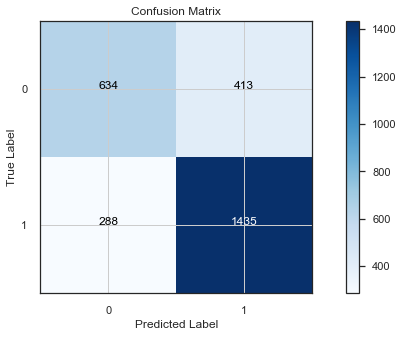

In [59]:
pipe_best_rf = Pipeline([('pca', PCA(n_components=17)),
                    ('clf', RandomForestClassifier(max_depth=20, min_samples_split=0.01, n_estimators=100))])

pipe_best_rf.fit(X_train, y_train)

rf_y_hat_train = pipe_best_rf.predict(X_train)
rf_y_hat_test = pipe_best_rf.predict(X_test)

print("Random Forest score for training set:", round(pipe_best_rf.score(X_train, y_train),5))
print("Random Forest score for test set:", round(pipe_best_rf.score(X_test, y_test),5))
print("\nClassification report:")
print(classification_report(y_test, rf_y_hat_test))
plot_cf(y_test, rf_y_hat_test)

# Model 4: XGBoost

In [60]:
pipe_xgb = Pipeline([('pca', PCA(n_components=17)),
                    ('clf', xgb.XGBClassifier())])
pipe_xgb.fit(X_train, y_train)
print("Score:", round(pipe_xgb.score(X_test, y_test),5))

C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:17:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Score: 0.74116


In [230]:
xgb_start = time.time()

pipe_xgb = Pipeline([('pca', PCA(n_components=17)),
                    ('clf', xgb.XGBClassifier())])

params_xgb = [ 
  {'clf__n_estimators': [100],
   'clf__max_depth': [25, 35],
   'clf__learning_rate': [0.01, 0.1],
   'clf__subsample': [0.7, 1],
   'clf__min_child_weight': [20, 100]
  }
]

grid_xgb = GridSearchCV(estimator=pipe_xgb,
                  param_grid=params_xgb,
                  cv=5)

grid_xgb.fit(X_train, y_train)

xgb_end = time.time()

xgb_best_score = grid_xgb.best_score_
xgb_best_params = grid_xgb.best_params_

print(f"Time taken to run: {round((xgb_end - xgb_start)/60,1)} minutes")
print("Best accuracy:", round(xgb_best_score,2))
print("Best parameters:", xgb_best_params)

C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:22:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:22:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:22:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:22:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:22:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:22:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:22:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:22:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:22:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:22:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:22:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:22:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:22:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:22:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:22:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:22:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:22:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:22:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:22:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:22:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:22:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:22:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Time taken to run: 1.4 minutes
Best accuracy: 0.75
Best parameters: {'clf__learning_rate': 0.1, 'clf__max_depth': 25, 'clf__min_child_weight': 20, 'clf__n_estimators': 100, 'clf__subsample': 1}


# Best XGBoost model

C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:18:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost score for training set: 0.8861
XGBoost score for test set: 0.7509

Classification report:
              precision    recall  f1-score   support

           0       0.69      0.62      0.65      1047
           1       0.78      0.83      0.81      1723

    accuracy                           0.75      2770
   macro avg       0.74      0.72      0.73      2770
weighted avg       0.75      0.75      0.75      2770



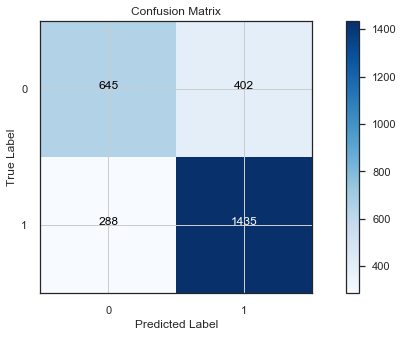

In [61]:
pipe_best_xgb = Pipeline([('pca', PCA(n_components=17)),
                    ('clf', xgb.XGBClassifier(learning_rate=0.1, max_depth=25, min_child_weight=20, n_estimators=100, subsample=1))])

pipe_best_xgb.fit(X_train, y_train)

xgb_y_hat_train = pipe_best_xgb.predict(X_train)
xgb_y_hat_test = pipe_best_xgb.predict(X_test)

print("XGBoost score for training set:", round(pipe_best_xgb.score(X_train, y_train),5))
print("XGBoost score for test set:", round(pipe_best_xgb.score(X_test, y_test),5))
print("\nClassification report:")
print(classification_report(y_test, xgb_y_hat_test))
plot_cf(y_test, xgb_y_hat_test)

# Model 5: Logistic regression with log-transformed data

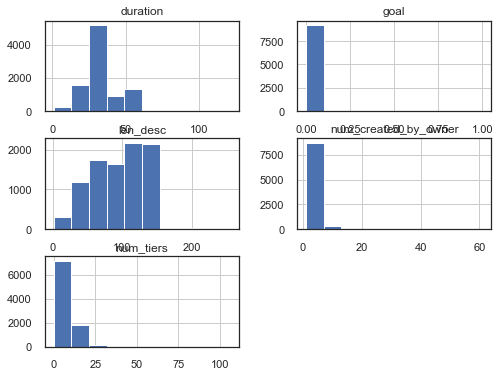

In [62]:
# Assessing skewed distributions
cols_to_log = ['duration', 'goal', 'len_desc','num_created_by_owner', 'num_tiers']
df_transformed1[cols_to_log].hist(figsize=(8,6));

In [63]:
# Replacing 0s with 0.01 and log-transforming
for col in cols_to_log:
    df_transformed1[col] = df_transformed1[col].astype('float64').replace(0.0, 0.01)
    df_transformed1[col] = np.log(df_transformed1[col])

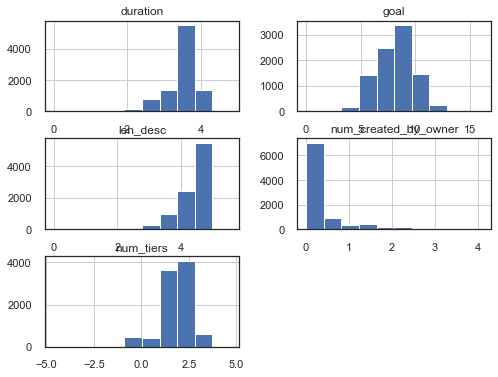

In [64]:
# Checking new distributions
df_transformed1[cols_to_log].hist(figsize=(8,6));

In [65]:
X_unscaled_log = df_transformed1.drop('status_Successful', axis=1)
y_log = df_transformed1['status_Successful']

In [66]:
# Transforming the data
scaler = StandardScaler()
X_log = pd.DataFrame(scaler.fit_transform(X_unscaled_log), columns=list(X_unscaled_log.columns))
X_log.head()

,googletrends,duration,goal,len_desc,len_title,num_tiers,num_created_by_owner,category_Comics,category_Crafts,category_Dance,category_Design,category_Fashion,category_Film&Video,category_Food,category_Games,category_Journalism,category_Music,category_Photography,category_Publishing,category_Technology,category_Theater,featured_Featured
0,-0.621960,0.054431,-0.671731,0.906921,-1.519260,-0.538298,-0.464884,-0.290838,-0.160199,-0.080199,-0.327039,-0.278384,3.535120,-0.22821,-0.485672,-0.07882,-0.278836,-0.117157,-0.348536,-0.298867,-0.075987,-0.37534
1,0.540694,-0.022550,0.970314,-3.994930,-1.714824,-0.903010,-0.464884,-0.290838,-0.160199,-0.080199,-0.327039,3.592160,-0.282876,-0.22821,-0.485672,-0.07882,-0.278836,-0.117157,-0.348536,-0.298867,-0.075987,-0.37534
2,1.288114,-0.022550,0.998790,-1.834315,-2.040763,0.171159,-0.464884,-0.290838,-0.160199,-0.080199,3.057740,-0.278384,-0.282876,-0.22821,-0.485672,-0.07882,-0.278836,-0.117157,-0.348536,-0.298867,-0.075987,-0.37534
3,1.205067,1.604764,-0.778142,0.800588,0.110435,-0.538298,-0.464884,-0.290838,-0.160199,-0.080199,-0.327039,-0.278384,-0.282876,-0.22821,-0.485672,-0.07882,-0.278836,8.535573,-0.348536,-0.298867,-0.075987,-0.37534
4,0.997451,-0.022550,0.565759,-1.138819,-1.323697,-1.417042,-0.464884,-0.290838,-0.160199,-0.080199,-0.327039,-0.278384,-0.282876,-0.22821,-0.485672,-0.07882,-0.278836,-0.117157,-0.348536,-0.298867,-0.075987,-0.37534


In [67]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, test_size=0.3, random_state=123)

Logistic regression score for training set: 0.77344
Logistic regression score for test set: 0.76823

Classification report:
              precision    recall  f1-score   support

           0       0.72      0.64      0.68      1047
           1       0.79      0.85      0.82      1723

    accuracy                           0.77      2770
   macro avg       0.76      0.74      0.75      2770
weighted avg       0.77      0.77      0.77      2770



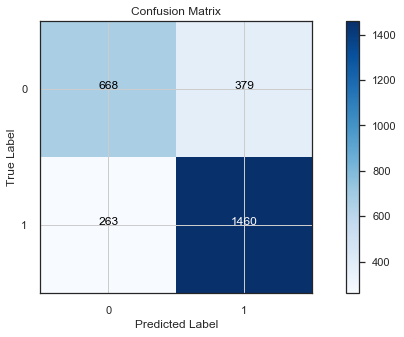

In [68]:
# Fitting a logistic regression model with default parameters
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

# Making predictions
lr_y_hat_train2 = logreg.predict(X_train)
lr_y_hat_test2 = logreg.predict(X_test)

# Logistic regression scores
print("Logistic regression score for training set:", round(logreg.score(X_train, y_train),5))
print("Logistic regression score for test set:", round(logreg.score(X_test, y_test),5))
print("\nClassification report:")
print(classification_report(y_test, lr_y_hat_test2))
# Confusion matrix
plot_cf(y_test, lr_y_hat_test2)

# Model 6: Random Forests without PCA

In [239]:
# Using GridSearchCV to test multiple different parameters
rf_start2 = time.time()

rf2 = RandomForestClassifier(min_samples_split=0.001, verbose=2)

params_rf2 = [ 
  {'n_estimators': [200, 400],
   'max_depth': [20, 35]
  }
]

grid_rf2 = GridSearchCV(estimator=rf2, param_grid=params_rf2, cv=5)

grid_rf2.fit(X_train, y_train)

rf_end2 = time.time()

rf_best_score2 = grid_rf2.best_score_
rf_best_params2 = grid_rf2.best_params_

print(f"Time taken to run: {round((rf_end2 - rf_start2)/60,1)} minutes")
print("Best accuracy:", round(rf_best_score2,2))
print("Best parameters:", rf_best_params2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 6

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
b

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
b

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
b

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
b

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
b

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
b

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
b

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
b

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
b

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
b

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
b

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    3.1s finished


Random Forest score for training set: 0.96193
Random Forest score for test set: 0.78375

Classification report:
              precision    recall  f1-score   support

           0       0.75      0.65      0.69      1047
           1       0.80      0.87      0.83      1723

    accuracy                           0.78      2770
   macro avg       0.77      0.76      0.76      2770
weighted avg       0.78      0.78      0.78      2770



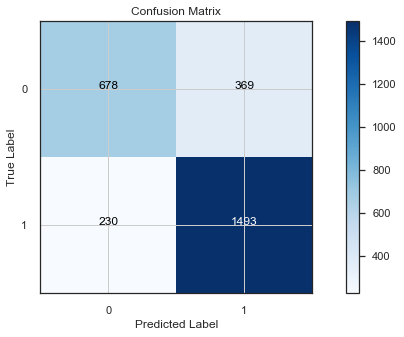

In [69]:
best_rf = RandomForestClassifier(max_depth=35, min_samples_split=0.001, n_estimators=400)

best_rf.fit(X_train, y_train)

rf_y_hat_train2 = best_rf.predict(X_train)
rf_y_hat_test2 = best_rf.predict(X_test)

print("Random Forest score for training set:", round(best_rf.score(X_train, y_train),5))
print("Random Forest score for test set:", round(best_rf.score(X_test, y_test),5))
print("\nClassification report:")
print(classification_report(y_test, rf_y_hat_test2))
plot_cf(y_test, rf_y_hat_test2)

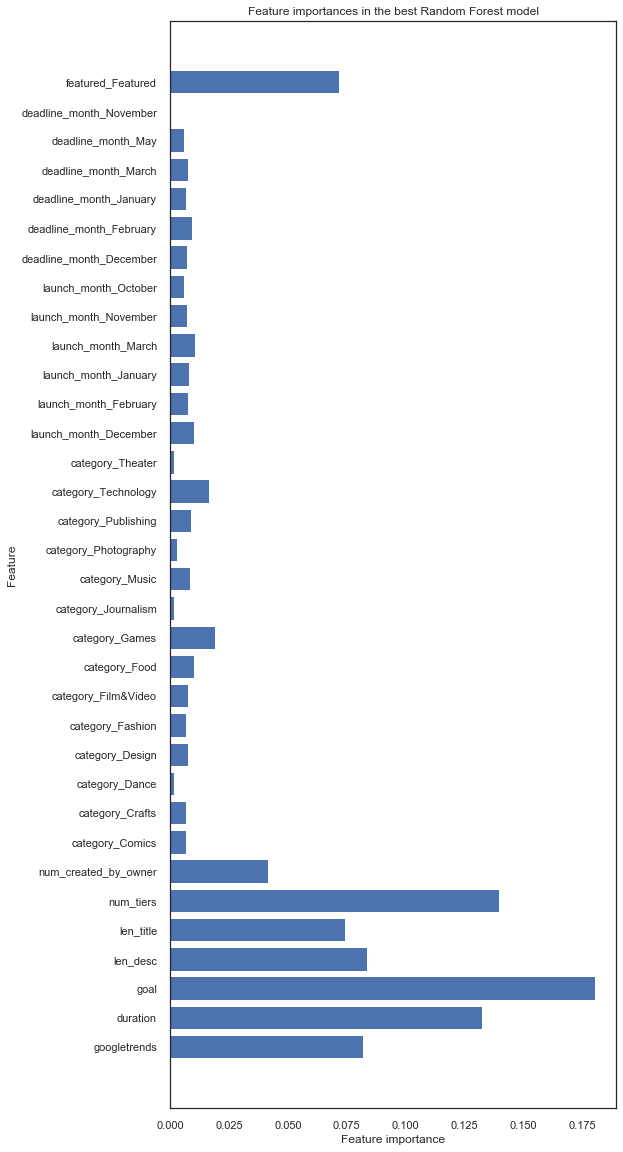

In [108]:

# Plotting feature importance
n_features = X_train.shape[1]
plt.figure(figsize=(8,20))
plt.barh(range(n_features), best_rf.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), X_train.columns.values) 
plt.title("Feature importances in the best Random Forest model")
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.show()

# Model 7: XGBoost without PCA

In [246]:
# Using GridSearchCV to test multiple different parameters
xgb_start2 = time.time()

xgb2 = xgb.XGBClassifier(learning_rate=0.1, max_depth=35, verbose=2)

params_xgb2 = [ 
  {'n_estimators': [100, 200],
   'subsample': [0.7, 0.9],
   'min_child_weight': [100, 200]
  }
]

grid_xgb2 = GridSearchCV(estimator=xgb2, param_grid=params_xgb2, cv=5)

grid_xgb2.fit(X_train, y_train)

xgb_end2 = time.time()

xgb_best_score2 = grid_xgb2.best_score_
xgb_best_params2 = grid_xgb2.best_params_

print(f"Time taken to run: {round((xgb_end2 - xgb_start2)/60,1)} minutes")
print("Best accuracy:", round(xgb_best_score2,2))
print("Best parameters:", xgb_best_params2)

C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:29:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:29:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:29:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but sl

C:\Users\L.Arustamyan\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:22:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost score for training set: 0.80501
XGBoost score for test set: 0.7787

Classification report:
              precision    recall  f1-score   support

           0       0.74      0.64      0.69      1047
           1       0.80      0.86      0.83      1723

    accuracy                           0.78      2770
   macro avg       0.77      0.75      0.76      2770
weighted avg       0.78      0.78      0.77      2770



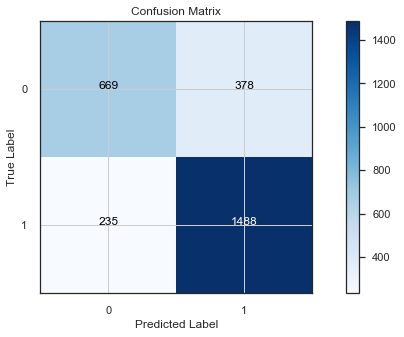

In [72]:

best_xgb = xgb.XGBClassifier(learning_rate=0.1, max_depth=35, min_child_weight=100, n_estimators=200, subsample=0.9)

best_xgb.fit(X_train, y_train)

xgb_y_hat_train2 = best_xgb.predict(X_train)
xgb_y_hat_test2 = best_xgb.predict(X_test)

print("XGBoost score for training set:", round(best_xgb.score(X_train, y_train),5))
print("XGBoost score for test set:", round(best_xgb.score(X_test, y_test),5))
print("\nClassification report:")
print(classification_report(y_test, xgb_y_hat_test2))
plot_cf(y_test, xgb_y_hat_test2)

# Model 8: kNN neighbors

In [248]:
# Using GridSearchCV to test multiple different parameters
knn_start2 = time.time()
knn = KNeighborsClassifier(n_neighbors = 5)

params_knn = [ 
  {'n_neighbors': [i for i in range(1,100)],
   
  }
]

grid_knn = GridSearchCV(estimator=knn, param_grid=params_knn, cv=5)

grid_knn.fit(X_train, y_train)

knn_end2 = time.time()

knn_best_score = grid_knn.best_score_
knn_best_params = grid_knn.best_params_

print(f"Time taken to run: {round((knn_end2 - knn_start2)/60,1)} minutes")
print("Best accuracy:", round(knn_best_score,2))
print("Best parameters:", knn_best_params)

Time taken to run: 3.5 minutes
Best accuracy: 0.76
Best parameters: {'n_neighbors': 28}


kNN score for training set: 0.77948
kNN score for test set: 0.76029

Classification report:
              precision    recall  f1-score   support

           0       0.71      0.62      0.66      1047
           1       0.78      0.85      0.81      1723

    accuracy                           0.76      2770
   macro avg       0.75      0.73      0.74      2770
weighted avg       0.76      0.76      0.76      2770



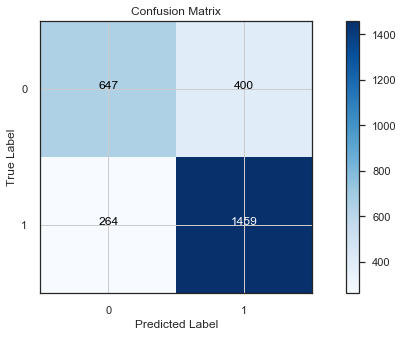

In [73]:
best_knn = KNeighborsClassifier(n_neighbors = 28)

best_knn.fit(X_train, y_train)

knn_y_hat_train = best_knn.predict(X_train)
knn_y_hat_test = best_knn.predict(X_test)

print("kNN score for training set:", round(best_knn.score(X_train, y_train),5))
print("kNN score for test set:", round(best_knn.score(X_test, y_test),5))
print("\nClassification report:")
print(classification_report(y_test, knn_y_hat_test))
plot_cf(y_test, knn_y_hat_test)

# Model 9: kNN neighbors with PCA

In [ ]:
# Using GridSearchCV to test multiple different parameters
knn_start2 = time.time()
pipe_knn = Pipeline([('pca', PCA(n_components=30)),
                    ('clf', KNeighborsClassifier(n_neighbors = 5))])


params_knn = [ 
  {'n_neighbors': [i for i in range(1,400)],
   
  }
]

grid_knn = GridSearchCV(estimator=pipe_knn, param_grid=params_knn, cv=5)

grid_knn.fit(X_train, y_train)

knn_end2 = time.time()

knn_best_score2 = grid_knn.best_score_
knn_best_params2 = grid_knn.best_params_

print(f"Time taken to run: {round((knn_end2 - knn_start2)/60,1)} minutes")
print("Best accuracy:", round(knn_best_score2,2))
print("Best parameters:", knn_best_params2)

kNN score for training set: 0.77236
kNN score for test set: 0.76065

Classification report:
              precision    recall  f1-score   support

           0       0.71      0.62      0.66      1047
           1       0.79      0.85      0.81      1723

    accuracy                           0.76      2770
   macro avg       0.75      0.73      0.74      2770
weighted avg       0.76      0.76      0.76      2770



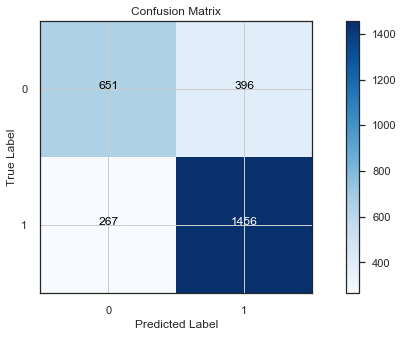

In [74]:
pipe_best_knn = Pipeline([('pca', PCA(n_components=17)),
                    ('clf', KNeighborsClassifier(n_neighbors = 28))])

pipe_best_knn.fit(X_train, y_train)

knn_y_hat_train2 = pipe_best_knn.predict(X_train)
knn_y_hat_test2 = pipe_best_knn.predict(X_test)

print("kNN score for training set:", round(pipe_best_knn.score(X_train, y_train),5))
print("kNN score for test set:", round(pipe_best_knn.score(X_test, y_test),5))
print("\nClassification report:")
print(classification_report(y_test, knn_y_hat_test2))
plot_cf(y_test, knn_y_hat_test2)

# Choosing a final model

In [86]:
# Extracting weighted average precision, recall and test scores for each best model
# Logistic regression log trasformed 
lr_test_precision, lr_test_recall, lr_test_f1score, lr_test_support = precision_recall_fscore_support(y_test, lr_y_hat_test2, average='weighted')
lr_train_precision, lr_train_recall, lr_train_f1score, lr_train_support = precision_recall_fscore_support(y_train, lr_y_hat_train2, average='weighted')
# Random Forest
rf_test_precision, rf_test_recall, rf_test_f1score, rf_test_support = precision_recall_fscore_support(y_test, rf_y_hat_test2, average='weighted')
rf_train_precision, rf_train_recall, rf_train_f1score, rf_train_support = precision_recall_fscore_support(y_train, rf_y_hat_train2, average='weighted')
# XGBoost
xgb_test_precision, xgb_test_recall, xgb_test_f1score, xgb_test_support = precision_recall_fscore_support(y_test, xgb_y_hat_test2, average='weighted')
xgb_train_precision, xgb_train_recall, xgb_train_f1score, xgb_train_support = precision_recall_fscore_support(y_train, xgb_y_hat_train2, average='weighted')
# kNN with PCA
knn_test_precision, knn_test_recall, knn_test_f1score, knn_test_support = precision_recall_fscore_support(y_test, knn_y_hat_test2, average='weighted')
knn_train_precision, knn_train_recall, knn_train_f1score, knn_train_support = precision_recall_fscore_support(y_train, knn_y_hat_train2, average='weighted')

In [87]:
# Logistic regression results
lr_results = {'Precision':[lr_train_precision, lr_test_precision], 'Recall':[lr_train_recall, lr_test_recall], 'F1_score': [lr_train_f1score, lr_test_f1score]}
lr_results = pd.DataFrame(lr_results, index=['Train', 'Test'])
print("Best logistic regression results (Model 5):")
lr_results

Best logistic regression results (Model 5):


,Precision,Recall,F1_score
Train,0.771400,0.773445,0.771274
Test,0.765032,0.768231,0.765209


In [88]:
# kNN regression results
knn_results = {'Precision':[knn_train_precision, knn_test_precision], 'Recall':[knn_train_recall, knn_test_recall], 'F1_score': [knn_train_f1score, knn_test_f1score]}
knn_results = pd.DataFrame(knn_results, index=['Train', 'Test'])
print("Best kNN regression results (Model 9):")
knn_results

Best kNN regression results (Model 9):


,Precision,Recall,F1_score
Train,0.770397,0.772361,0.769001
Test,0.757063,0.760650,0.757112


In [89]:
# Random Forest results
rf_results = {'Precision':[rf_train_precision, rf_test_precision], 'Recall':[rf_train_recall, rf_test_recall], 'F1_score': [rf_train_f1score, rf_test_f1score]}
rf_results = pd.DataFrame(rf_results, index=['Train', 'Test'])
print("Best Random Forest results (Model 6):")
rf_results

Best Random Forest results (Model 6):


,Precision,Recall,F1_score
Train,0.962378,0.961931,0.961756
Test,0.780988,0.783755,0.780259


In [90]:
# XGBoost results
xgb_results = {'Precision':[xgb_train_precision, xgb_test_precision], 'Recall':[xgb_train_recall, xgb_test_recall], 'F1_score': [xgb_train_f1score, xgb_test_f1score]}
xgb_results = pd.DataFrame(xgb_results, index=['Train', 'Test'])
print("Best XGBoost results (Model 7):")
xgb_results

Best XGBoost results (Model 7):


,Precision,Recall,F1_score
Train,0.804084,0.805014,0.802348
Test,0.775738,0.778700,0.774999


In [91]:
r_cf = confusion_matrix(y_test, rf_y_hat_test2)
print("Evaluation of the final model:")
print("\nIf the true value is failure, what proportion does the model correctly predict as a failure? \n(True negative rate/specificity):\n", round(r_cf[0][0]/sum(r_cf[0]),4))
print("If the true value is success, what proportion does the model correctly predict as a success? \n(True positive rate/recall/sensitivity):\n", round(r_cf[1][1]/sum(r_cf[1]),4))
print("\nIf the model predicts a failure, what proportion are actually failures? \n(Negative prediction value):\n", round(r_cf[0][0]/sum(r_cf[:,0]),4))
print("If the model predicts a success, what proportion are actually successes? \n(Positive prediction value/precision):\n", round(r_cf[1][1]/sum(r_cf[:,1]),4))

Evaluation of the final model:

If the true value is failure, what proportion does the model correctly predict as a failure? 
(True negative rate/specificity):
 0.6476
If the true value is success, what proportion does the model correctly predict as a success? 
(True positive rate/recall/sensitivity):
 0.8665

If the model predicts a failure, what proportion are actually failures? 
(Negative prediction value):
 0.7467
If the model predicts a success, what proportion are actually successes? 
(Positive prediction value/precision):
 0.8018
